### **AdaBoost**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

lung_cancer = pd.read_csv("survey lung cancer.csv")
lung_cancer.head()

,GENDER,AGE,SMOKING,YELLOW_FINGERS,ANXIETY,PEER_PRESSURE,CHRONIC DISEASE,FATIGUE,ALLERGY,WHEEZING,ALCOHOL CONSUMING,COUGHING,SHORTNESS OF BREATH,SWALLOWING DIFFICULTY,CHEST PAIN,LUNG_CANCER
0,M,69,1,2,2,1,1,2,1,2,2,2,2,2,2,YES
1,M,74,2,1,1,1,2,2,2,1,1,1,2,2,2,YES
2,F,59,1,1,1,2,1,2,1,2,1,2,2,1,2,NO
3,M,63,2,2,2,1,1,1,1,1,2,1,1,2,2,NO
4,F,63,1,2,1,1,1,1,1,2,1,2,2,1,1,NO


In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
lung_cancer["GENDER"] = le.fit_transform(lung_cancer["GENDER"])
lung_cancer["LUNG_CANCER"] = le.fit_transform(lung_cancer["LUNG_CANCER"])
print(lung_cancer[["GENDER", "LUNG_CANCER"]].head())

   GENDER  LUNG_CANCER
0       1            1
1       1            1
2       0            0
3       1            0
4       0            0


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split

X = lung_cancer.drop("LUNG_CANCER", axis=1)
y = lung_cancer["LUNG_CANCER"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
SEED = 1
weak_learner = DecisionTreeClassifier(max_depth=6,
                            min_samples_leaf=6,
                            max_leaf_nodes=8,
                            criterion="entropy",
                            random_state=SEED)
ada_clf = AdaBoostClassifier(estimator=weak_learner,
                         n_estimators=300,
                         random_state=SEED,
                         learning_rate=0.5)
ada_clf.fit(X_train, y_train)
y_pred_proba = ada_clf.predict_proba(X_test)[:,1]

In [ ]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score

dummy_clf = DummyClassifier(strategy="most_frequent",
                            random_state=SEED)
dummy_clf.fit(X_train, y_train)

def misclassification_error(y_true, y_pred):
    return 1 - accuracy_score(y_true, y_pred)

weak_learners_misclassification_error = misclassification_error(
    y_test, weak_learner.fit(X_train, y_train).predict(X_test)
)

dummy_classifiers_misclassification_error = misclassification_error(
    y_test, dummy_clf.fit(X_train, y_train).predict(X_test)
)

print(
    "DecisionTreeClassifier's misclassification_error: "
    f"{weak_learners_misclassification_error:.3f}"
)
print(
    "DummyClassifier's misclassification_error: "
    f"{dummy_classifiers_misclassification_error:.3f}"
)

DecisionTreeClassifier's misclassification_error: 0.097
DummyClassifier's misclassification_error: 0.032


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


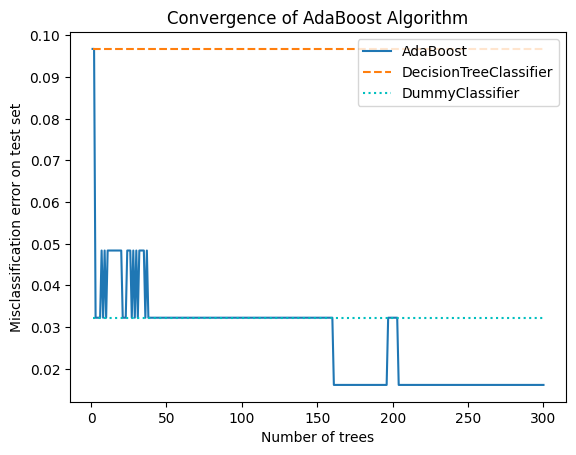

In [ ]:
n_estimators = 300

boosting_errors = pd.DataFrame(
    {
        "Number of trees": range(1, n_estimators + 1),
        "AdaBoost": [
            misclassification_error(y_test, y_pred)
            for y_pred in ada_clf.staged_predict(X_test)
        ],
    }
).set_index("Number of trees")
ax = boosting_errors.plot()
ax.set_ylabel("Misclassification error on test set")
ax.set_title("Convergence of AdaBoost Algorithm")

plt.plot(
    [boosting_errors.index.min(), boosting_errors.index.max()],
    [weak_learners_misclassification_error, weak_learners_misclassification_error],
    color="tab:orange",
    linestyle="dashed",
)
plt.plot(
    [boosting_errors.index.min(), boosting_errors.index.max()],
    [
        dummy_classifiers_misclassification_error,
        dummy_classifiers_misclassification_error,
    ],
    color="c",
    linestyle="dotted",
)
plt.legend(["AdaBoost", "DecisionTreeClassifier", "DummyClassifier"], loc=1)
plt.show()

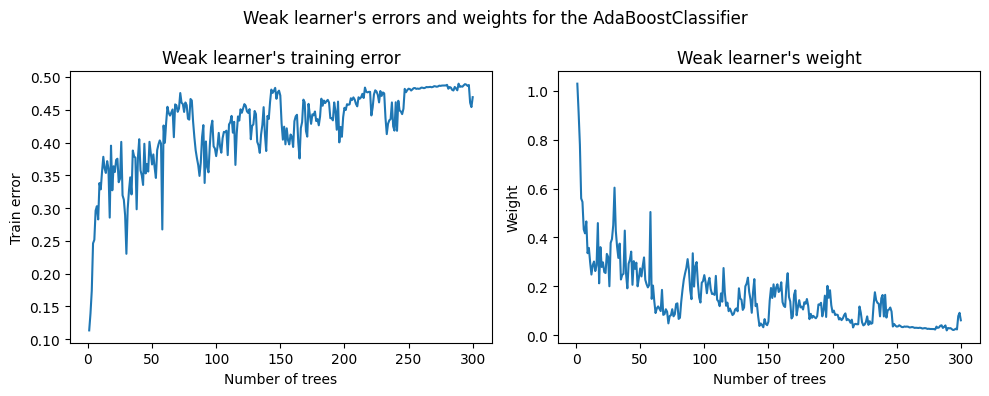

In [ ]:
weak_learners_info = pd.DataFrame(
    {
        "Number of trees": range(1, n_estimators + 1),
        "Errors": ada_clf.estimator_errors_,
        "Weights": ada_clf.estimator_weights_,
    }
).set_index("Number of trees")

axs = weak_learners_info.plot(
    subplots=True, layout=(1, 2), figsize=(10, 4), legend=False, color="tab:blue"
)
axs[0, 0].set_ylabel("Train error")
axs[0, 0].set_title("Weak learner's training error")
axs[0, 1].set_ylabel("Weight")
axs[0, 1].set_title("Weak learner's weight")
fig = axs[0, 0].get_figure()
fig.suptitle("Weak learner's errors and weights for the AdaBoostClassifier")
fig.tight_layout()

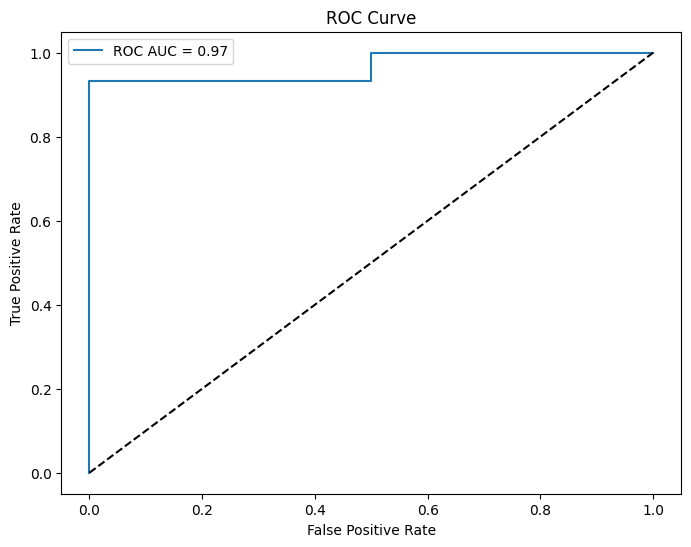

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix

# 1. ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba, pos_label=1)  # Ensure pos_label is correct

# Calculate the ROC AUC score
test_roc_auc = roc_auc_score(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC AUC = {test_roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


Feature Importances:
                  Feature  Importance
0                     AGE    0.347641
1                ALLERGY     0.075711
2          YELLOW_FINGERS    0.070292
3     SHORTNESS OF BREATH    0.066435
4                 ANXIETY    0.054985
5       ALCOHOL CONSUMING    0.052213
6   SWALLOWING DIFFICULTY    0.050894
7           PEER_PRESSURE    0.043050
8         CHRONIC DISEASE    0.042260
9                 SMOKING    0.041762
10               FATIGUE     0.041383
11             CHEST PAIN    0.033527
12               WHEEZING    0.030159
13               COUGHING    0.026002
14                 GENDER    0.023684


<ipython-input-34-3e562e1fe4e5>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=features_df, palette='viridis')


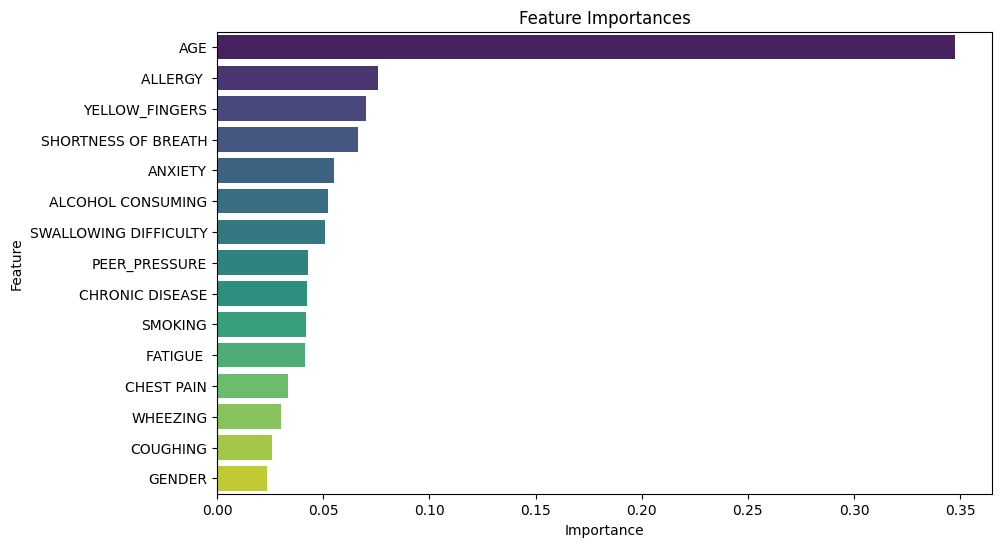

In [ ]:
# 2. Feature Importance (AdaBoost provides this directly)
feature_importances = ada_clf.feature_importances_  # Access feature importances directly

features_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})
features_df = features_df.sort_values('Importance', ascending=False).reset_index(drop=True)

print("\nFeature Importances:")
print(features_df)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=features_df, palette='viridis')
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

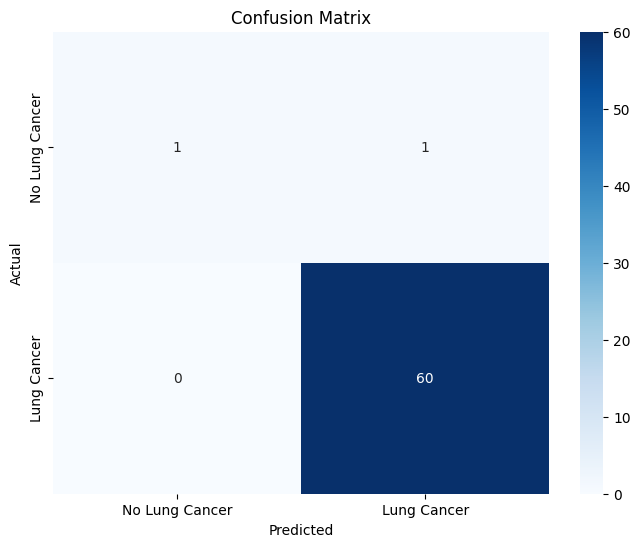

In [ ]:
# 3. Confusion Matrix
y_pred = ada_clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Lung Cancer', 'Lung Cancer'],
            yticklabels=['No Lung Cancer', 'Lung Cancer'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()